In [2]:
#shenanigans so python finds weak_sauce module 
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
print sys.path

['', '/u/ki/mbaumer/local/pappy', '/afs/slac.stanford.edu/u/ki/mbaumer/random_pixel_size/weak_sauce/notebooks', '/u/ki/mbaumer/local/lib/python2.7/site-packages', '/u/ki/mbaumer/anaconda/lib/python27.zip', '/u/ki/mbaumer/anaconda/lib/python2.7', '/u/ki/mbaumer/anaconda/lib/python2.7/plat-linux2', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-tk', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-old', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-dynload', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/cryptography-0.9.1-py2.7-linux-x86_64.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/setuptools-17.1.1-py2.7.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/IPython/extensions', '/u/ki/mbaumer/random_pixel_size/weak_sauce/code']


In [3]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover, FixedIlluminationMover
from weak_sauce.fit_flat import FlatFitter

def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))
    
#import galsim

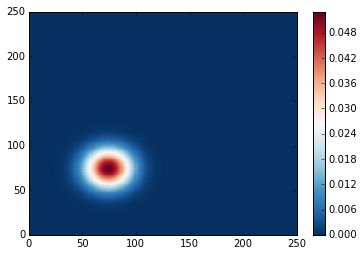

In [7]:
n_verts_x = 51
stationary_source = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, flux_func=gauss, mu=(15,15),sigma=3)
stationary_source.plot(stationary_source.fluxes)

def galsim_flux_func(centroids, **kwargs):
    test_obj = galsim.Gaussian(sigma=3)
    test_obj = test_obj.shift(15,15)
    fluxes = np.zeros((centroids.shape[0],centroids.shape[1]))
    for i in np.arange(centroids.shape[0]):
        for j in np.arange(centroids.shape[1]):
            fluxes[i,j] = test_obj.xValue(centroids[i,j,0],centroids[i,j,1])
    return fluxes
src2 = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, flux_func=galsim_flux_func)

In [7]:
#test_obj = galsim.Gaussian(sigma=3)
n_verts_x = 51
src2 = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, flux_func=n_verts_x)
src2.plot_pixel_grid()

TypeError: youve got galsim imported, but your flux_func still wasnt a function or a galsim GSObject

In [27]:
var_type = eval('galsim.GSObject')
issubclass(type(test_obj),var_type)

True

In [15]:
try: 
    import asdfas
except ImportError:
    print ('hello')

hello


0.0253302959106


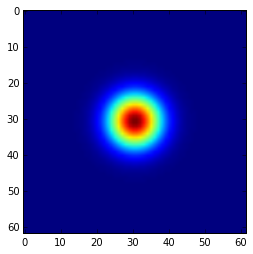

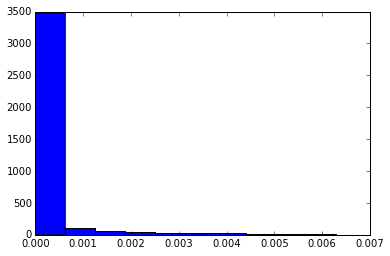

In [49]:
test = galsim.Gaussian(sigma=1)
img = test.drawImage(scale=.2)
plt.imshow(img.array)
plt.figure()
_ = plt.hist(img.array.flatten())
test.getFlux()
print test.xValue(0,0)/(np.pi*2)

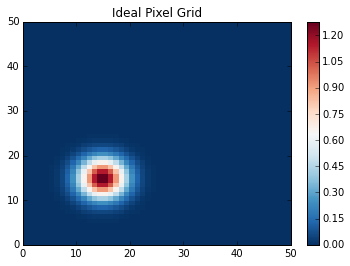

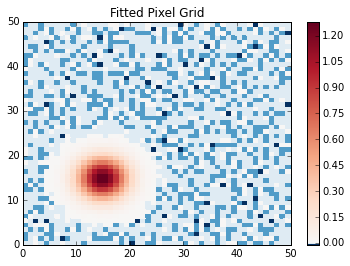

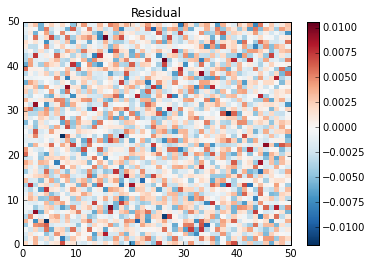

In [7]:
from weak_sauce.adaptive_moments.psf_evaluator import Moment_Evaluator

#temp = MoveableGrid('test100k_iter.pkl')
temp = MoveableGrid('../data/test100k_iter.pkl')
flat = np.load('../data/data_rel_flux_map_50x50.npy')
n_verts_x = 51

stationary_source = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, flux_func=gauss, mu=(15,15),sigma=3)
illuminator = FixedIlluminationMover(stationary_source)

ideal_grid = Source(num_x=n_verts_x)
ideal_mg = MoveableGrid(ideal_grid,illuminator)
ideal_mg.step()
ideal_mg.plot_real_grid()
plt.title('Ideal Pixel Grid')

temp.source.fluxes -= 1
temp.source.psf_evaluator = Moment_Evaluator(num_iter_max = 1000)
mg = MoveableGrid(temp.source, illuminator)
mg.step()
mg.source.fluxes /= flat
mg.plot_real_grid()
plt.title('Fitted Pixel Grid')

mg.source.plot(mg.source.fluxes-ideal_mg.source.fluxes)
plt.title('Residual')

NameError: name 'ws' is not defined